## MCB 288 - Spring 2019 - Exercise 1

For week 2 we will be reanalyzing data from this paper:

https://rnajournal.cshlp.org/content/22/6/839.long

In which the authors did 96 RNA-seq experiments, 48 replicates each of wildtype yeast cells (S. cerevisiae) and an otherwise isogenic line carrying a mutation in the transcription factor SNF2. The main goal of the paper, which we will focus on here, was to ask the question of how many replicates are needed to accurately identify genes that are differentially expressed between the two conditions.

I have preprocessed the data a little bit to put it into a tabular form available in the file:

##### data/Barton/Barton_combined_Ygenes.txt

The file is a tab-delimited table whose rows are genes and columns are replicates. 

In the paper they identify several replicates that look unusual and which they do not include in subsequent analyses. We will discuss whether this was appropriate, but it is certainly true that several of the samples are unusual in that they look quite different from other supposedly identical samples.

#### Your assignment is to identify these outliers and describe what makes them unusual. You should be able to do this using only operations discussed in the last class. But I will start you off with some code to help.

In [6]:
# import libraries 

import pandas as pd

# this is here to shut off some annoying warnings from pandas
pd.options.mode.chained_assignment = None

# matplotlib is one of the main plotting libraries we're going to use
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline

# the other plotting library is seaborn - we'll use both during the class

import seaborn as sns

# numpy and scipy are for handling numerical and scientific data

import numpy as np
import scipy as sp

import statsmodels.formula.api as smf # basic statistical modeling

from scipy.stats.stats import pearsonr 

In [8]:
# load dataframe with expression data

datafile = "data/barton/Barton_combined_Ygenes.txt"
df = pd.read_csv(datafile, sep='\t')   # the sep='\t' tells pandas that it is a tab separated file

#
# Index dataframe on 'Gene'
#

df = df.set_index('Gene')

df.head()



,Snf2_rep01,Snf2_rep02,Snf2_rep03,Snf2_rep04,Snf2_rep05,Snf2_rep06,Snf2_rep07,Snf2_rep08,Snf2_rep09,Snf2_rep10,...,WT_rep39,WT_rep40,WT_rep41,WT_rep42,WT_rep43,WT_rep44,WT_rep45,WT_rep46,WT_rep47,WT_rep48
Gene,,,,,,,,,,,,,,,,,,,,,
YAL001C,840,653,823,1036,510,820,1240,549,828,738,...,353,696,492,445,419,289,541,292,647,409
YAL002W,712,530,607,771,395,605,904,351,589,533,...,356,756,552,440,389,291,552,346,622,453
YAL003W,7296,6129,6464,7278,5613,3046,7687,6714,8382,7678,...,9291,12055,13542,8441,7337,8639,14315,6618,14745,9878
YAL004W,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
YAL005C,9851,10226,12006,10714,8575,2791,11764,8237,12213,12446,...,10177,21176,13270,12337,14303,14268,14993,9607,16075,14797


Not that the first column is "Gene" and uses the standard identifier for yeast genes which has several components:

Take the first one as an example: YAL001C

* Y - is for yeast
* A - tells you what chromosome it is on (A is chromosome 1, B is chromosome 2, etc...). Yeast has 16 chromosomes plus mitcochondria.
* L - is for the left arm of the chromosome (the other arm is R for right)
* 001 - is a numerical identifier counting genes along the chromosome arm
* C - says that it is on the "Crick" strand - the other option is W for "Watson" (we should all get together and lobby to have this changed to F for Franklin)

You can get all sorts of info on yeast genes at the Yeast Genome Database www.yeastgenome.org.



In [32]:
# you will likely want to use lists of experiments 

# this comment gets all of the column names and puts them into a list

exps = {}

exps['all'] = df.columns.get_values()

# you can then create lists with just WT and Snf2 mutants

# the syntax here in English is 
# [] create a new list
# [e for e in exps] fills the list with all values from the list exps
# if e.startswith('WT') filters the list to only include elements that start with 'WT'



exps['wt'] = [e for e in exps['all'] if e.startswith('WT')] 

exps['mut'] = [e for e in exps['all'] if e.startswith('Snf2')] 

In [33]:
#
# create a matrix to store correlation
#

datalen = len(exps['all'])
corrdata = np.zeros( (datalen,datalen))

for i1,e1 in enumerate(exps['all']):
    for i2,e2 in enumerate(exps['all']):
        corrdata[i1][i2] = pearsonr(df[e1],df[e2])[0] 
      

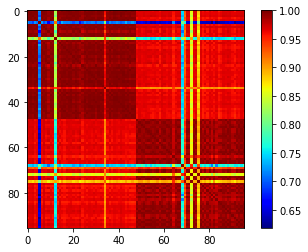

In [34]:
# plot data as a heatmap 
# this option maps every cell in the table into a colored pixel
# the cmap options controls how the mapping is done

plt.imshow(corrdata, cmap='jet')
plt.colorbar()

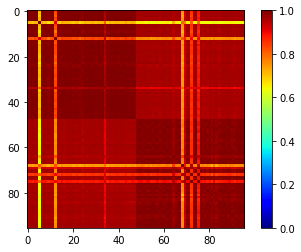

In [35]:
# plot data as a heatmap 
# this option maps every cell in the table into a colored pixel
# the cmap, vmin and vmax options controls how the mapping is done

plt.imshow(corrdata, cmap='jet',vmin=0, vmax=1.0)
plt.colorbar()

Note several things about the data:

1) Most of the correlations are very high -- over .90.
2) There is generally a higher correlation within wts (the upper left quadrant) and muts (the lower right quadrant) than between them (lower left and upper right).
3) There are around 6 experiments that show poor coorelation with the rest of the data and we might want to consider them for exclusion.

We don't want to rely on staring at an image to identify the outliers though, so instead lets calculate for each sample its average correlation with other samples of the same type. 

Text(0.5, 0, 'average within experiment type correlation')

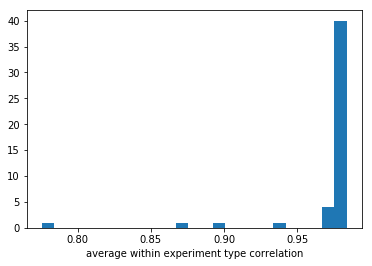

In [55]:
stype = 'wt'

avecorrs = []
for i1,e1 in enumerate(exps[stype]):
    corrs = []
    for i2,e2 in enumerate(exps[stype]):
        if i1 != i2:
            corrs.append(pearsonr(df[e1],df[e2])[0])
    avecorrs.append(np.mean(corrs))

plt.hist(avecorrs,bins=25)
plt.xlabel("average within experiment type correlation")

Text(0.5, 0, 'average within experiment type correlation')

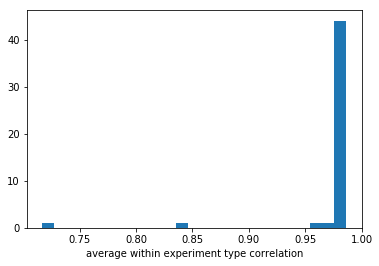

In [54]:
stype = 'mut'

avecorrs = []
for i1,e1 in enumerate(exps[stype]):
    corrs = []
    for i2,e2 in enumerate(exps[stype]):
        if i1 != i2:
            corrs.append(pearsonr(df[e1],df[e2])[0])
    avecorrs.append(np.mean(corrs))

plt.hist(avecorrs, bins=25)
plt.xlabel("average within experiment type correlation")

In both cases it looks like a cutoff of 0.95 seems reasonable. So let's do that. 

In [61]:
exps_filt = {}
exps_filt['all'] = []

corrcutoff = .95 

for stype in ['wt','mut']:
    for i1,e1 in enumerate(exps[stype]):
        corrs = []
        for i2,e2 in enumerate(exps[stype]):
            if i1 != i2:
                corrs.append(pearsonr(df[e1],df[e2])[0])
        if np.mean(corrs) > corrcutoff:
            exps_filt['all'].append(e1)
        
exps_filt['wt'] = [e for e in exps_filt['all'] if e.startswith('WT')] 

exps_filt['mut'] = [e for e in exps_filt['all'] if e.startswith('Snf2')] 

In [62]:
#
# create a matrix to store correlation
#

datalen = len(exps_filt['all'])
corrdata = np.zeros( (datalen,datalen))

for i1,e1 in enumerate(exps_filt['all']):
    for i2,e2 in enumerate(exps_filt['all']):
        corrdata[i1][i2] = pearsonr(df[e1],df[e2])[0] 
      

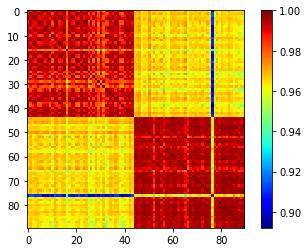

In [65]:
# plot data as a heatmap 
# this option maps every cell in the table into a colored pixel
# the cmap, vmin and vmax options controls how the mapping is done

plt.imshow(corrdata, cmap='jet')
plt.colorbar()

Still one possible outlier, but it's still strongly correlated with other experiments so let's leave it in. You can always revisit this later.